In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits

import os

from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import torch


In [4]:
import normflows as nf
from tqdm import tqdm

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## GENERATE DATA

In [6]:
import torch.utils.data as data
class half_circle(data.Dataset):
    r'''Generate a dataset of points on a half circle.'''
    def __init__(self, n=512):
        super(half_circle, self).__init__()
        self.n = n
    
    def __getitem__(self, index):
        r = 1.0
        phi = torch.rand(1) * torch.pi
        x = torch.cos(phi) * r
        y = torch.sin(phi) * r
        return torch.cat((x, y), 0) + torch.randn(2) / 20
    
    def __len__(self):
        return self.n

## Normalizing flow

In [116]:
trainingdata = data.DataLoader(half_circle(n=1000), batch_size=64)

In [388]:
num_layers = 4
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 50, 32, 10, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

In [374]:
target_dist = nf.distributions.DiagGaussian(1)

In [375]:
model = nf.NormalizingFlow(target_dist, flows)

In [359]:
model

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=1, out_features=32, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=32, out_features=50, bias=True)
              (3): LeakyReLU(negative_slope=0.0)
              (4): Linear(in_features=50, out_features=32, bias=True)
              (5): LeakyReLU(negative_slope=0.0)
              (6): Linear(in_features=32, out_features=10, bias=True)
              (7): LeakyReLU(negative_slope=0.0)
              (8): Linear(in_features=10, out_features=2, bias=True)
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Permute()
    (2): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
  

In [377]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [378]:
target_dist = nf.distributions.DiagGaussian(2)

In [379]:
loss_count = []
for i in range(50):
    losses = []
    for x in trainingdata:
        optimizer.zero_grad()
        z, logdet = model.forward_and_log_det(x)
        pz = target_dist.log_prob(z)
        logprob = pz + logdet
        loss = -logprob.mean()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    loss_count.append(np.mean(losses))

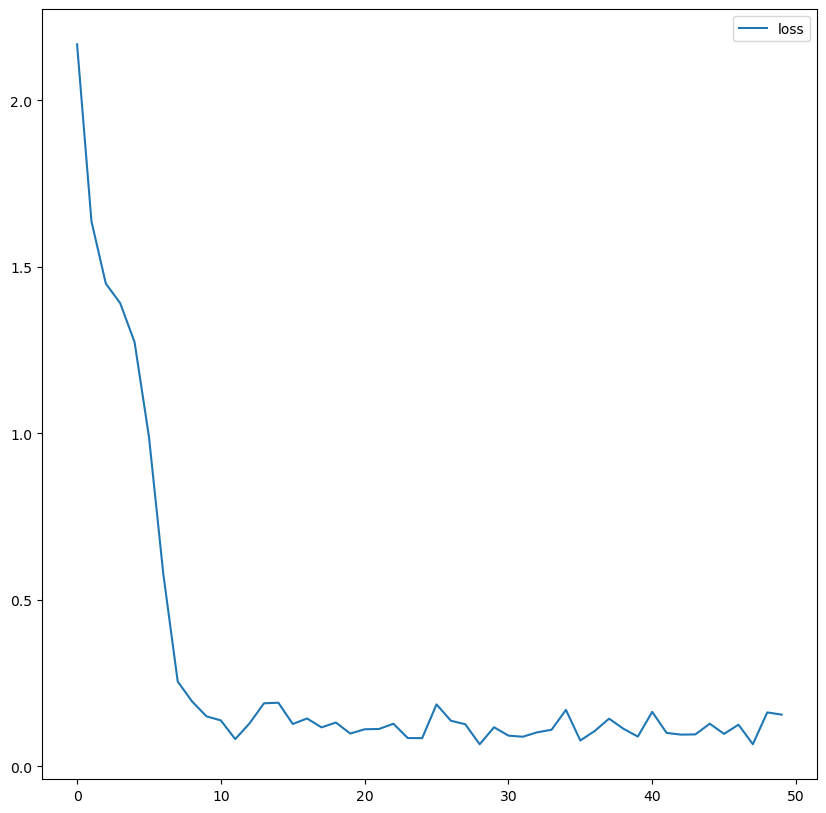

In [380]:
plt.figure(figsize=(10, 10))
plt.plot(loss_count, label='loss')
plt.legend()
plt.show()

## SAMPLE GENERATION

In [381]:
target_dist = nf.distributions.DiagGaussian(2)

In [386]:
list_=[]
for i in range(500):
    s = target_dist.sample(1)
    c = model.inverse(s)
    list_.append(c.detach().cpu().numpy()[0])
list_= np.vstack(list_)

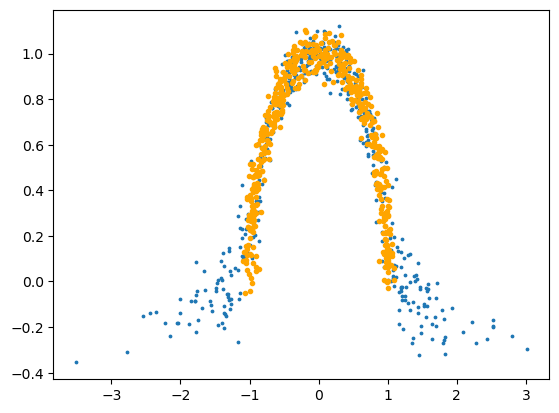

In [387]:
sampled = np.array([half_circle()[0].tolist() for i in range(500)])
plt.plot(sampled[:,0], sampled[:,1], '.', color ='orange')
plt.scatter(list_[:,0],list_[:,1], s=3)
plt.show()


## ANOTHER EXAMPLE

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


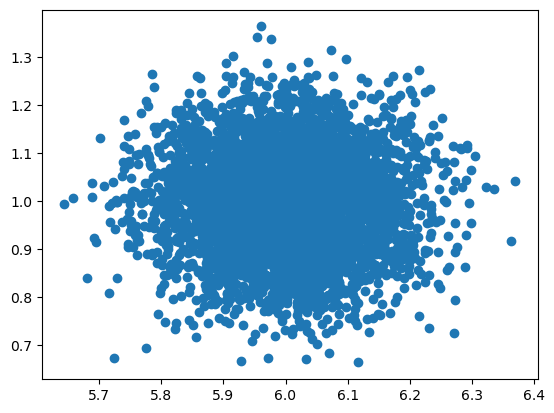

In [9]:
Nclass = 1
xs, ys = np.random.randint(0,10,Nclass),np.random.randint(0,10,Nclass)
Nsamp = 5000
training_sample = torch.zeros(size =(Nclass, Nsamp, 2))
label = torch.zeros(size =(Nclass, Nsamp, 8))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii] = torch.concat((xsamp,ysamp),1)
    #training_sample[ii,:,2:] =  training_sample[ii,:,2:] + 0.05*torch.randn(Nsamp,6)
    label[ii,:,ii] = 1
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [10]:
target_dist = nf.distributions.DiagGaussian(2)

In [11]:
prior_target = target_dist.sample(5000).detach().cpu().numpy()

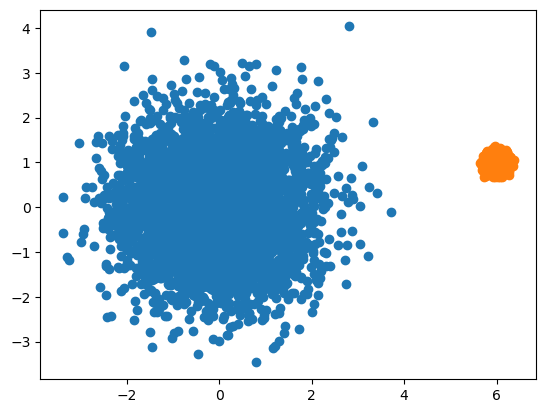

In [12]:
plt.scatter(prior_target[:,0],prior_target[:,1])
plt.scatter(xsamp,ysamp)

In [13]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
dset = TensorDataset(training_sample)
loader = DataLoader(dset, batch_size=100, shuffle=True)

In [14]:
num_layers = 4
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 50, 32, 10, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

In [15]:
model = nf.NormalizingFlow(target_dist, flows)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_count = []
for i in range(1):
    losses = []
    for x in loader:
        optimizer.zero_grad()
        z, logdet = model.forward_and_log_det(x[0])
        pz = target_dist.log_prob(z)
        logprob = pz + logdet
        loss = -logprob.mean()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    loss_count.append(np.mean(losses))

0 torch.Size([100, 2])
torch.Size([100, 2])
1 torch.Size([100, 2])
torch.Size([100, 2])
2 torch.Size([100, 2])
torch.Size([100, 2])
3 torch.Size([100, 2])
torch.Size([100, 2])
4 torch.Size([100, 2])
torch.Size([100, 2])
5 torch.Size([100, 2])
torch.Size([100, 2])
6 torch.Size([100, 2])
torch.Size([100, 2])
7 torch.Size([100, 2])
torch.Size([100, 2])
0 torch.Size([100, 2])
torch.Size([100, 2])
1 torch.Size([100, 2])
torch.Size([100, 2])
2 torch.Size([100, 2])
torch.Size([100, 2])
3 torch.Size([100, 2])
torch.Size([100, 2])
4 torch.Size([100, 2])
torch.Size([100, 2])
5 torch.Size([100, 2])
torch.Size([100, 2])
6 torch.Size([100, 2])
torch.Size([100, 2])
7 torch.Size([100, 2])
torch.Size([100, 2])
0 torch.Size([100, 2])
torch.Size([100, 2])
1 torch.Size([100, 2])
torch.Size([100, 2])
2 torch.Size([100, 2])
torch.Size([100, 2])
3 torch.Size([100, 2])
torch.Size([100, 2])
4 torch.Size([100, 2])
torch.Size([100, 2])
5 torch.Size([100, 2])
torch.Size([100, 2])
6 torch.Size([100, 2])
torch.Siz

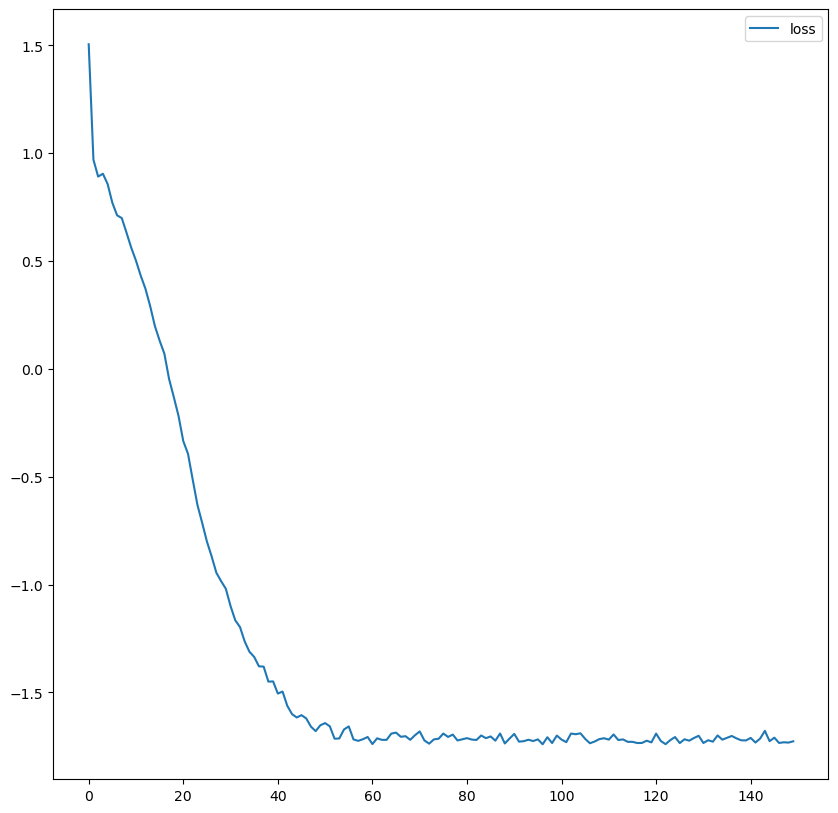

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(loss_count, label='loss')
plt.legend()
plt.show()

In [22]:
list_=[]
for i in range(1000):
    s = target_dist.sample(1)
    c = model.inverse(s)
    list_.append(c.detach().cpu().numpy()[0])
list_= np.vstack(list_)

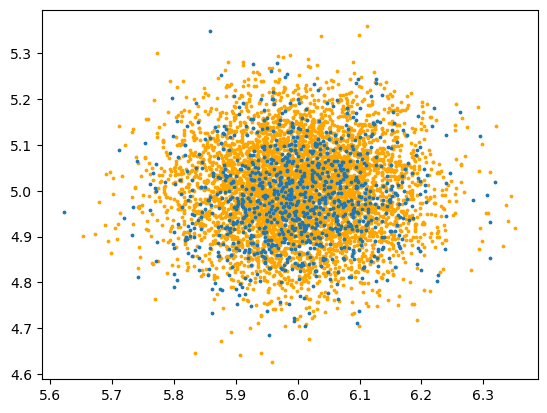

In [23]:
plt.scatter(xsamp,ysamp,color='orange',s=3)
plt.scatter(list_[:,0],list_[:,1], s=3)
plt.show()


# SAME CONDITIONAL

## CREATE DATA

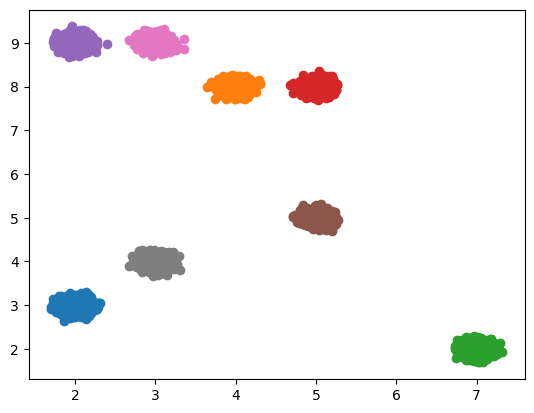

In [6]:
xs, ys = np.random.randint(0,10,8),np.random.randint(0,10,8)
Nclass = 8
Nsamp = 1000
training_sample = torch.zeros(size =(Nclass, Nsamp, 2))
condition = torch.zeros(size =(Nclass, Nsamp, 2))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii,:,:] = torch.concat((xsamp,ysamp),1)
    condition[ii,:] = torch.concat((torch.Tensor([x]).unsqueeze(1),torch.Tensor([y]).unsqueeze(1)),1)
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [7]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
condition = condition.reshape(Nsamp*Nclass,2)

dset = TensorDataset(training_sample,condition)
loader = DataLoader(dset, batch_size=100, shuffle=True)

### ENCODER

In [8]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, layers_size, output_layers, num_layers=1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.selected_out = OrderedDict()
        self.output_layers = output_layers
        self.fhooks = []
        
        for ii in range(len(layers_size)-1):
            self.layers.append(nn.Linear(layers_size[ii], layers_size[ii+1]))
        
        self.encoder = nn.Sequential(*self.layers)

        for i,l in enumerate(list(self.encoder._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.encoder,l).register_forward_hook(self.forward_hook(l)))

    def forward(self, vector):
        encoded_outputs = self.encoder(vector)
        return encoded_outputs, self.selected_out
                
                
    def forward_hook(self,layer_name):
        def hook(module, inp, out):
            self.selected_out[layer_name] = out
        return hook
        



In [9]:
from collections import OrderedDict 

In [22]:
encoder = Encoder(layers_size=[2,2,2],output_layers=[0,1,2])



In [23]:
num_layers = 2
flows = []
for i in range(num_layers):
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 50, 32, 10, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.nets.MLP([4,2,2]))
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    #flows.append(nf.flows.Permute(num_layers, mode='swap'))
    


In [24]:
target_dist = nf.distributions.DiagGaussian(2)

In [25]:
model = nf.NormalizingFlow(target_dist, flows)

for flow in model.flows:
    #print(flow)
    if isinstance(flow, nf.nets.MLP):
        print('f',flow)
    elif isinstance(flow, nf.flows.AffineCouplingBlock):
        print('f',flow)

In [34]:
optimizer_flow = optim.Adam(model.parameters(), lr=0.001)
optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)

loss_count = []
for i in range(100):
    losses = []
    for x,c in loader:
        optimizer_flow.zero_grad()
        optimizer_encoder.zero_grad()
        
        o,lay_out = encoder(c)
        z, logdet = model.forward_and_log_det(x,lay_out)
    
        pz = target_dist.log_prob(z)
        logprob = pz + logdet
        loss = -logprob.mean()
        loss.backward()
        losses.append(loss.item())
        optimizer_flow.step()
        optimizer_encoder.step()

    loss_count.append(np.mean(losses))

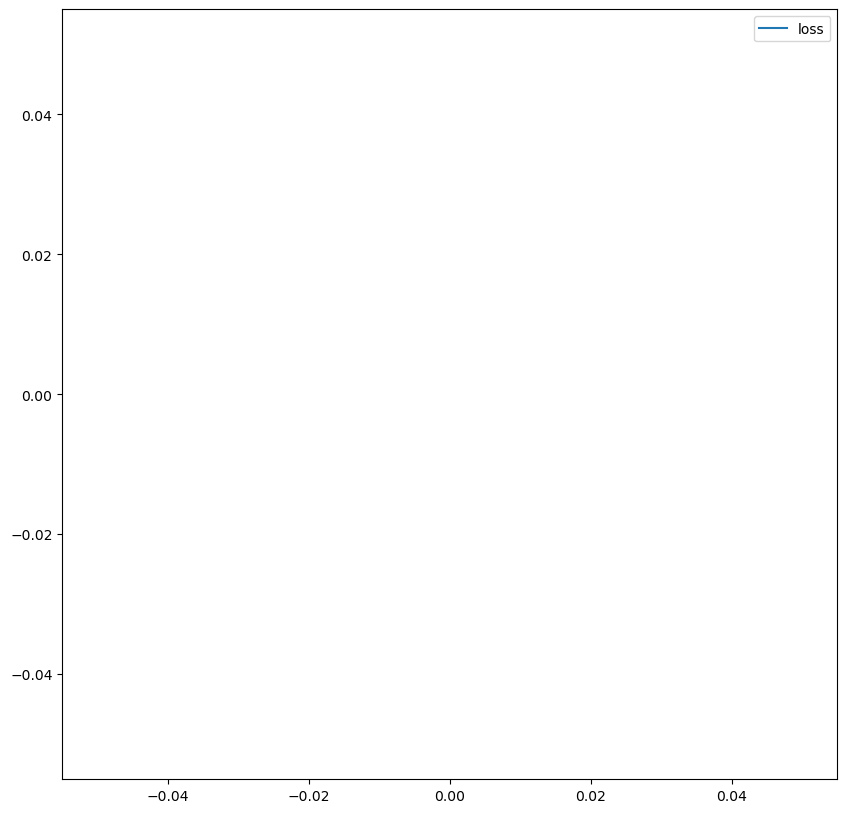

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(loss_count, label='loss')
plt.legend()
plt.show()

target_dist = nf.distributions.DiagGaussian(2)

In [28]:
ys

array([3, 8, 2, 8, 9, 5, 9, 4])

In [32]:
list_=[]
model = model.eval()
for i in range(1000):
    cx,cy = 2, 3
    cx,cy= torch.Tensor([cx]).unsqueeze(0), torch.Tensor([cy]).unsqueeze(0)
    c = torch.concat((cx,cy),1)
    o,lay_out = encoder(c)
    s = target_dist.sample(1)
    p = model.inverse(s,lay_out)
    list_.append(p.detach().cpu().numpy()[0])
list_= np.vstack(list_)

In [33]:
list_

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

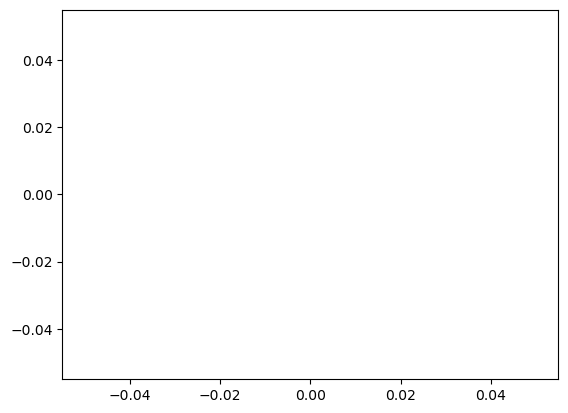

In [30]:
plt.scatter(list_[:,0],list_[:,1], s=3)
plt.show()


In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## NORMALIZING FLOW

# Define list of flows
num_layers = 8
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([4, 512, 512, 512, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

model = nf.NormalizingFlow(base, flows)

for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

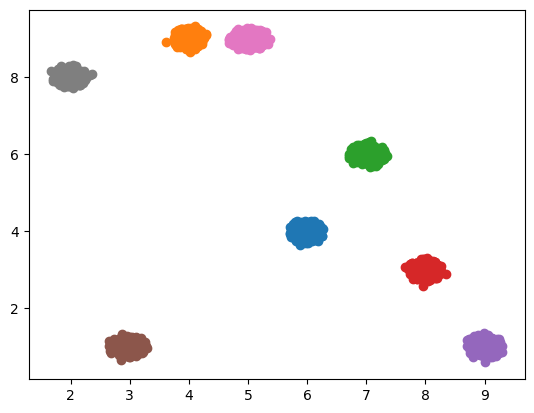

In [119]:
xs, ys = np.random.randint(0,10,8),np.random.randint(0,10,8)
Nclass = 8
Nsamp = 1000
training_sample = torch.zeros(size =(Nclass, Nsamp, 2))
label = torch.zeros(size =(Nclass, Nsamp, 8))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii] = torch.concat((xsamp,ysamp),1)
    #training_sample[ii,:,2:] =  training_sample[ii,:,2:] + 0.05*torch.randn(Nsamp,6)
    label[ii,:,ii] = 1
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [120]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
label = label.reshape(Nsamp*Nclass,8)

In [136]:
dset = TensorDataset(training_sample,label)
from torch.utils.data import random_split
dset_train, dset_val = random_split(dset, [int(0.9*len(dset)), int(0.1*len(dset))])

loader = DataLoader(dset_train, batch_size=100, shuffle=True)
loader_val = DataLoader(dset_val, batch_size=100, shuffle=False)

In [135]:
# Define flows
K = 4

latent_size = 2
hidden_units = 512
hidden_layers = 3
context_size=8
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units,
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    # Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

model = model.to(device)

In [122]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 2


In [140]:
context.shape

torch.Size([128, 4])

In [146]:
xx.shape

torch.Size([128, 2])

In [144]:
label.shape

torch.Size([8000, 8])

In [147]:
x.shape

torch.Size([100, 2])

In [ ]:
loss = model.forward_kld(x, context)

In [151]:
target = nf.distributions.target.ConditionalDiagGaussian()

In [152]:
target.log_prob?

Signature: target.log_prob(z, context=None)
Docstring:
Args:
  z: value or batch of latent variable

Returns:
  log probability of the distribution for z
File:      /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/distributions/target.py
Type:      method

In [158]:
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)

0
1
2
3
4
5
6
7
8
9


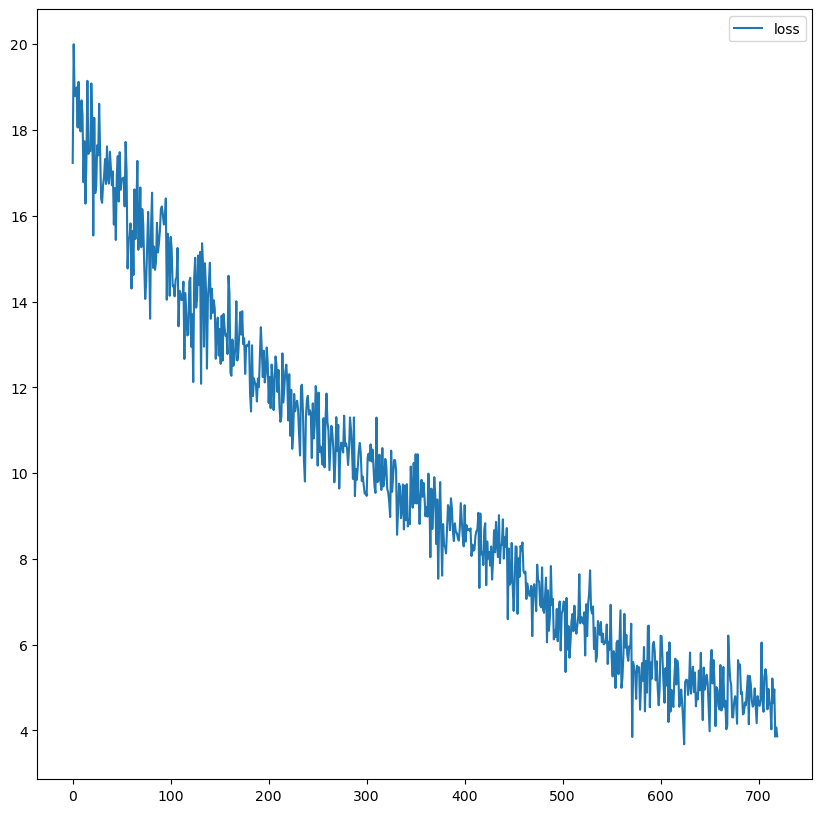

In [157]:
# Train model
max_iter = 10
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in range(max_iter):
    print(it)
    
    for x,y in loader:
        optimizer.zero_grad()
        loss = model.forward_kld(x.to(device), y.to(device))
        loss.backward()
        optimizer.step()
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [104]:
context_plot

tensor([[0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        ...,
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000]], device='cuda:0')

In [ ]:
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [73]:
base = nf.distributions.base.DiagGaussian(2)

In [79]:
model = nf.NormalizingFlow(base, flows)

In [82]:
for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

torch.Size([100, 8]) torch.Size([100, 8])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4 and 2x512)

In [17]:
target = nf.distributions.target.TwoMoons()

In [19]:
target?

Signature:      target(*input, **kwargs)
Type:           TwoMoons
String form:    TwoMoons()
File:           /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/distributions/target.py
Docstring:      Bimodal two-dimensional distribution
Init docstring:
Constructor

Args:
  prop_scale: Scale for the uniform proposal
  prop_shift: Shift for the uniform proposal

In [ ]:
base_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
target_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),
  1
)

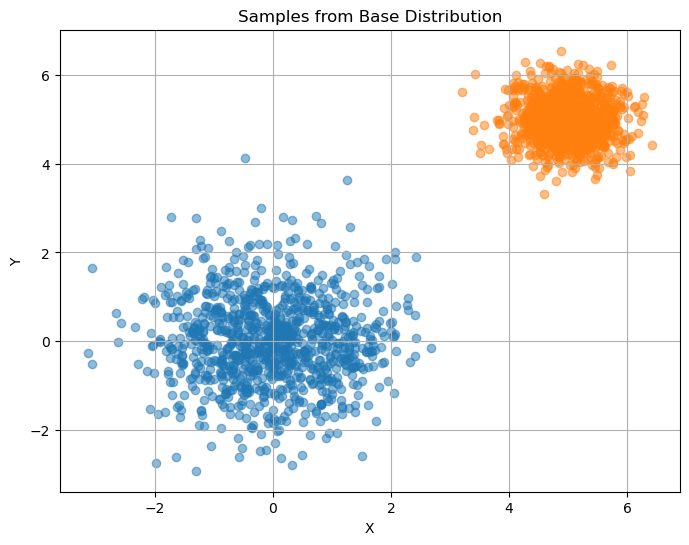

In [7]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

## CREATE NORMALIZING FLOW

#####Â Normalizing flow with a single transformation

In [8]:
bijectors = bij.AffineAutoregressive()

In [9]:
flow = dist.Flow(base_dist, bijectors)

In [10]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target_dist.sample((1000,))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()
    opt.step()

epoch 0 loss tensor(23.8129, grad_fn=<NegBackward0>)
epoch 500 loss tensor(3.6865, grad_fn=<NegBackward0>)
epoch 1000 loss tensor(3.2616, grad_fn=<NegBackward0>)
epoch 1500 loss tensor(3.0639, grad_fn=<NegBackward0>)
epoch 2000 loss tensor(2.5082, grad_fn=<NegBackward0>)
epoch 2500 loss tensor(1.6517, grad_fn=<NegBackward0>)
epoch 3000 loss tensor(1.4682, grad_fn=<NegBackward0>)


In [25]:
dist_y = dist.Flow(base_dist, bijectors)

In [28]:
num_samples = 1000
samples_pred = dist_y.sample((num_samples,))



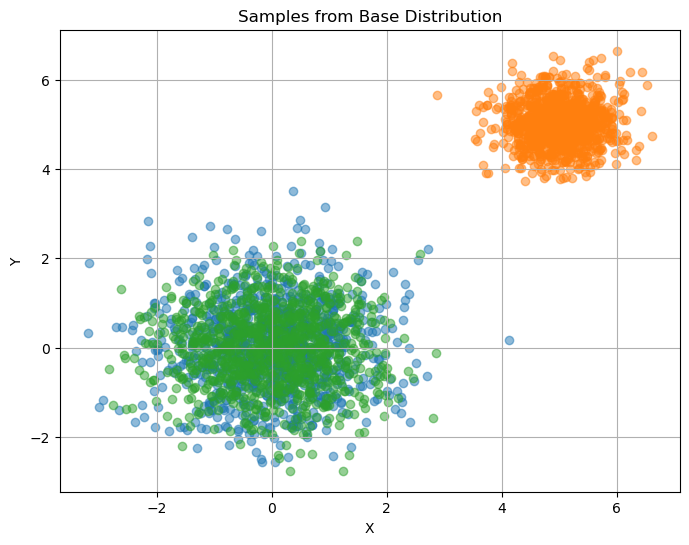

In [29]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Extract x and y coordinates for plotting
x_values_pred = samples_pred[:, 0].numpy()
y_values_pred = samples_pred[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)
plt.scatter(x_values_pred, y_values_pred, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

# SIMPLE EXAMPLE MAPPING FEATRUES INTO PROBABILITY DISTRIBUTIONS

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [62]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [63]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [64]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.715
iter 500: loss = 0.835
iter 1000: loss = 0.493
iter 1500: loss = 0.592
iter 2000: loss = 0.467
iter 2500: loss = 0.298
iter 3000: loss = 0.396
iter 3500: loss = 0.368
iter 4000: loss = 0.306
iter 4500: loss = 0.486
iter 5000: loss = 0.458


In [66]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()

In [68]:
z

array([[-1.8747659e-01,  3.8629249e-01],
       [-4.5098123e-01,  1.1165810e+00],
       [ 2.7200544e-01,  4.9045309e-01],
       ...,
       [-1.9135862e-03, -1.3994721e+00],
       [ 1.8429850e+00,  4.9667689e-01],
       [ 2.3594198e+00, -1.4860994e-01]], dtype=float32)

Text(0.5, 1.0, '$X = g(z)$')

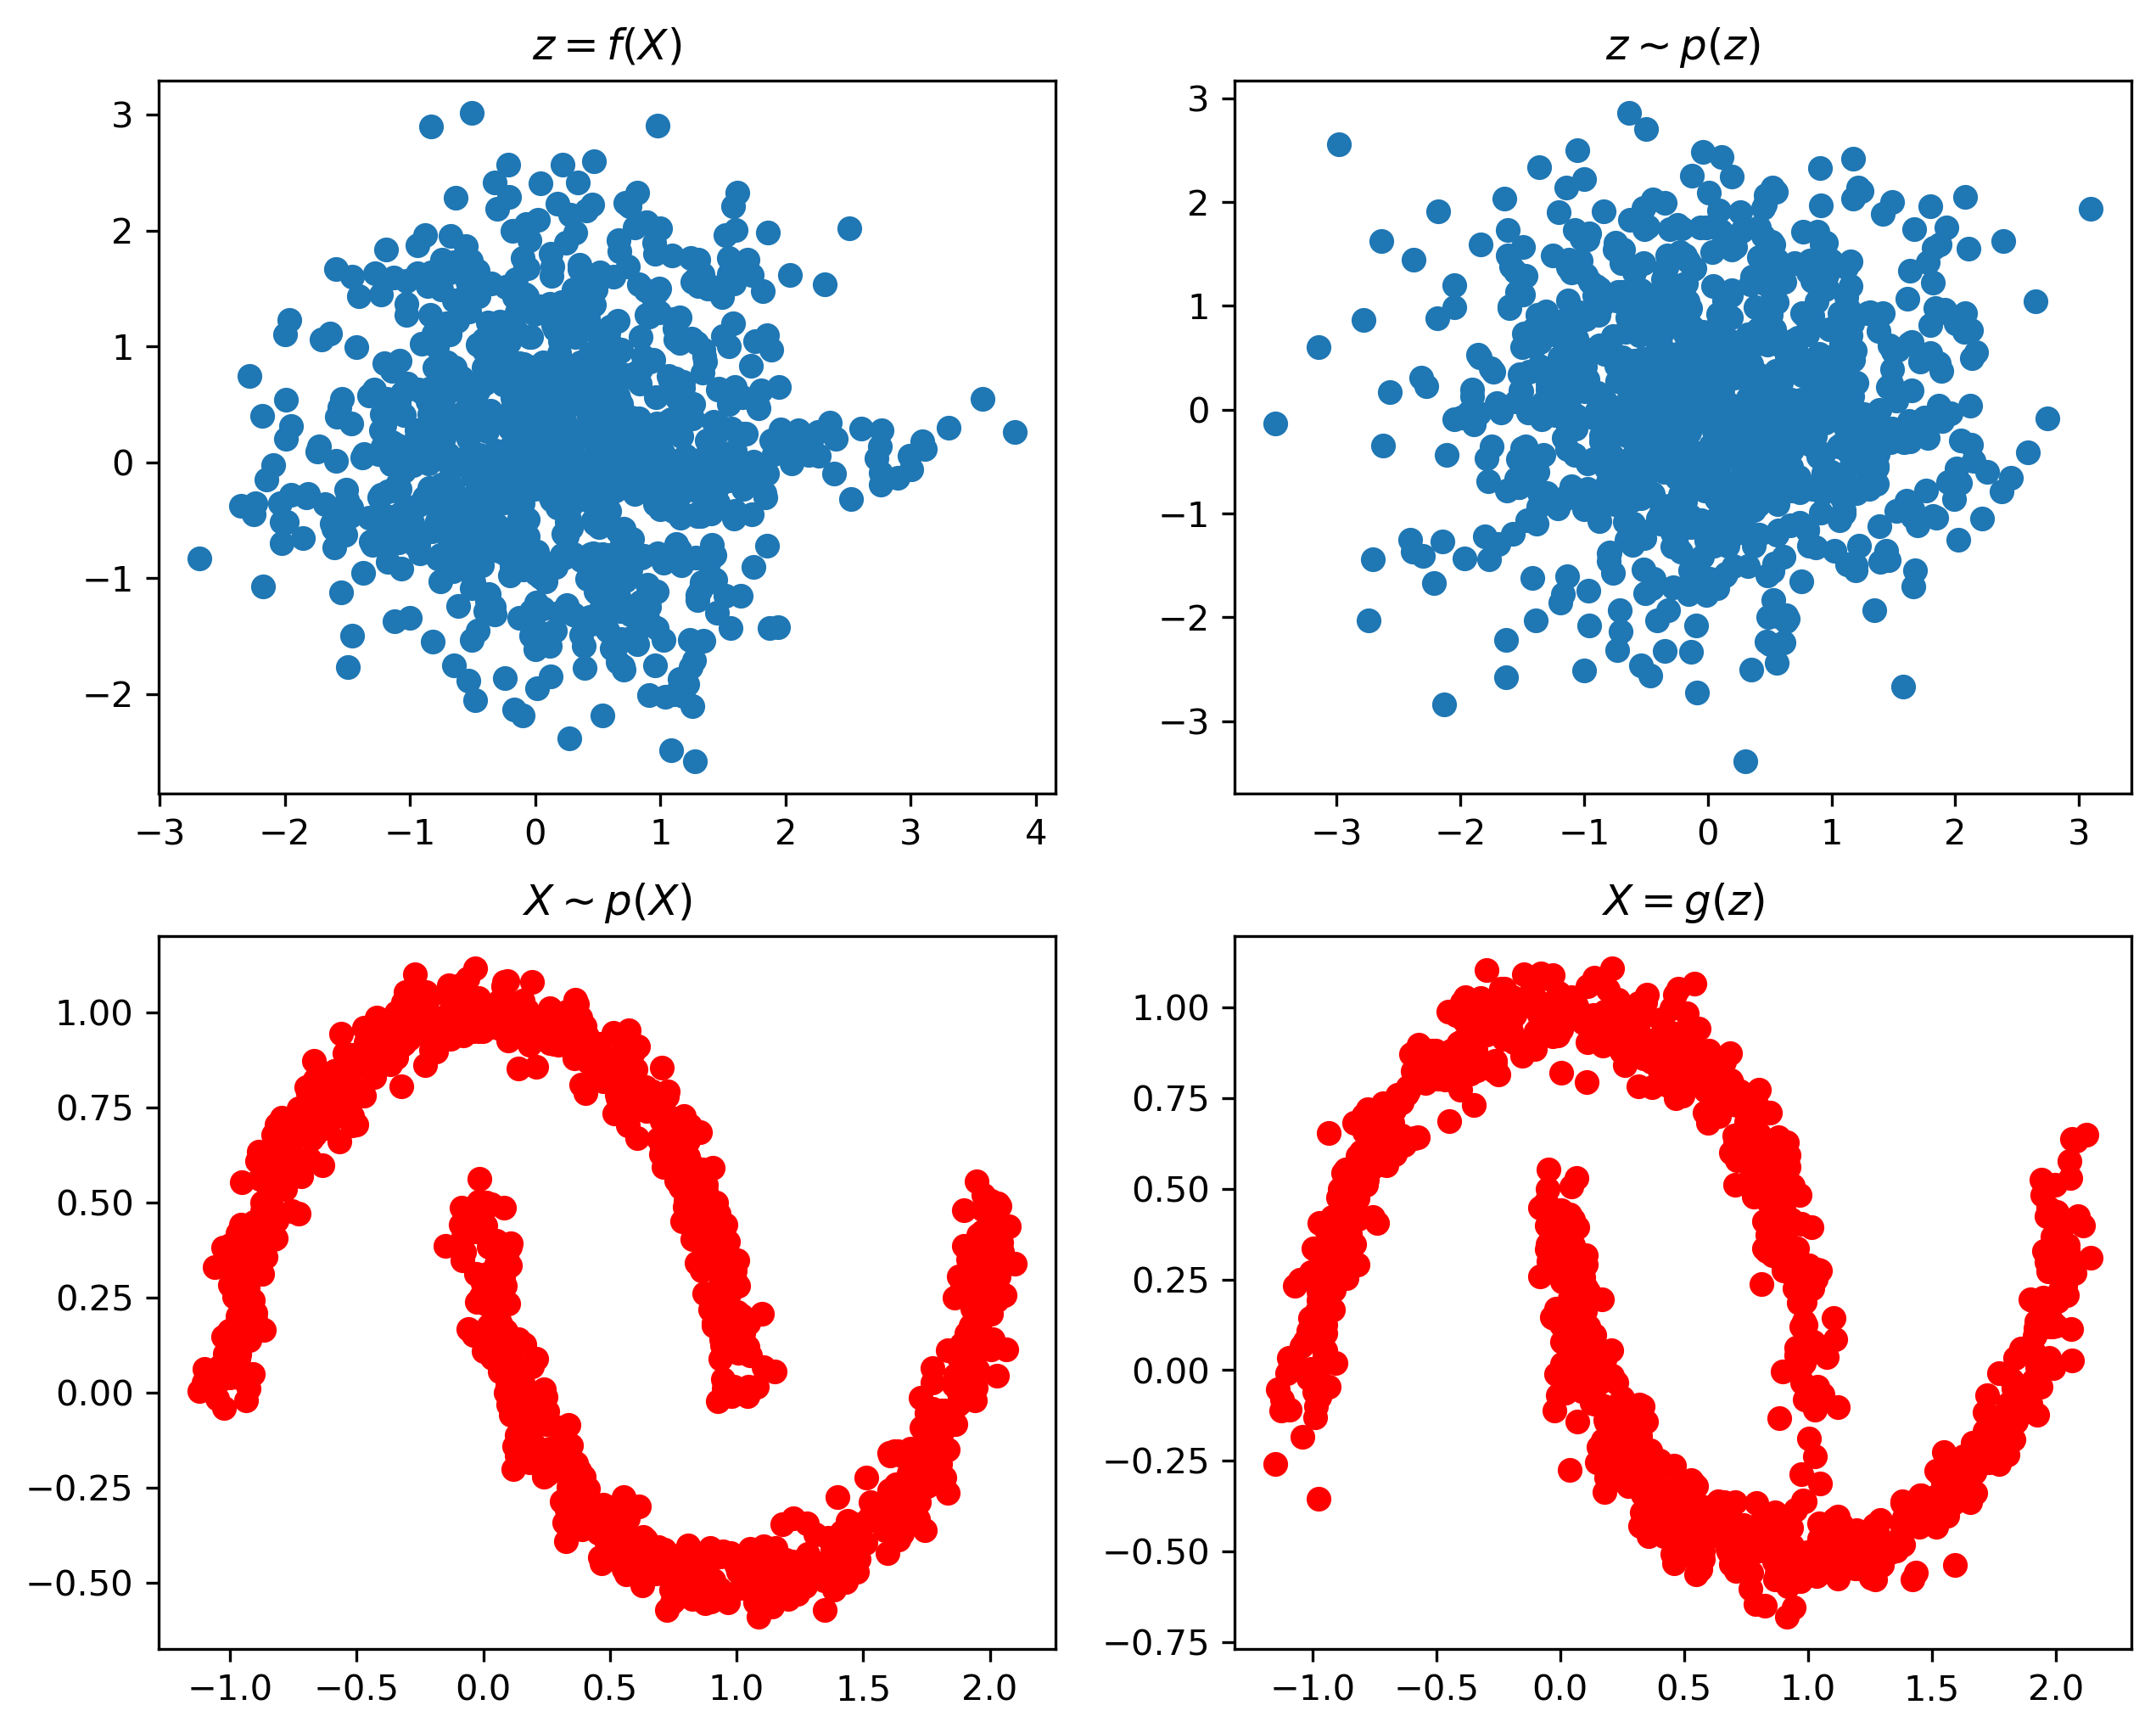

In [65]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## WITH NFLOWS

In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

In [3]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [4]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    print(x.shape, y.shape)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5,100)
        yline = torch.linspace(-.75, 1.25,100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()


torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([1


KeyboardInterrupt

